# Multiclass Classification

In [8]:
!pip install albumentations

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 631 kB 27.7 MB/s 
  Created wheel for imgaug: filename=imgaug-0.2.6-py3-none-any.whl size=654017 sha256=720ad72d27d35d1d9a134cb401e7097c6534bb3fe4cac974c84bddccc4304b70
  Stored in directory: /root/.cache/pip/wheels/89/72/98/3ebfdba1069a9a8eaaa7ae7265cfd67d63ef0197aaee2e5f9c
Successfully built imgaug
  Attempting uninstall: imgaug
    Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9


In [9]:
!pip install -U git+https://github.com/albu/albumentations --no-cache-dir

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-7ik1akgm
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-7ik1akgm
     |████████████████████████████████| 48.3 MB 1.6 MB/s 
  Created wheel for albumentations: filename=albumentations-1.2.0-py3-none-any.whl size=113474 sha256=694a8056100b17a3440894e92e9f7689a097230c54b9e1bcbb7068d198a32aa4
  Stored in directory: /tmp/pip-ephem-wheel-cache-71qsik_9/wheels/63/11/1a/c77caf3ae9b9b6d57b3ee5e6a41a50f3bc12c66a70f6b90bf0
Successfully built albumentations
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [10]:
!pip uninstall opencv-contrib-python

Found existing installation: opencv-contrib-python 4.1.2.30
Uninstalling opencv-contrib-python-4.1.2.30:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/cv2/*
    /usr/local/lib/python3.7/dist-packages/opencv_contrib_python-4.1.2.30.dist-info/*
  Would not remove (might be manually added):
    /usr/local/lib/python3.7/dist-packages/cv2/config-3.py
    /usr/local/lib/python3.7/dist-packages/cv2/config.py
    /usr/local/lib/python3.7/dist-packages/cv2/cv2.abi3.so
    /usr/local/lib/python3.7/dist-packages/cv2/gapi/__init__.py
    /usr/local/lib/python3.7/dist-packages/cv2/load_config_py2.py
    /usr/local/lib/python3.7/dist-packages/cv2/load_config_py3.py
    /usr/local/lib/python3.7/dist-packages/cv2/mat_wrapper/__init__.py
    /usr/local/lib/python3.7/dist-packages/cv2/misc/__init__.py
    /usr/local/lib/python3.7/dist-packages/cv2/misc/version.py
    /usr/local/lib/python3.7/dist-packages/cv2/utils/__init__.py
    /usr/local/lib/python3.7/dist-packages/cv2/version.py
Procee

In [12]:
!pip install opencv-contrib-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 67.1 MB 35 kB/s 


In [1]:
import os
import math

import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

os.environ['CUDA_VISIBLE_DEVICES'] = '3'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


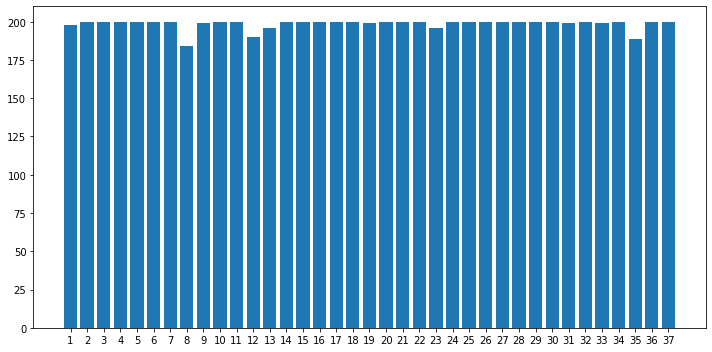

In [3]:
#Image CLASS-ID SPECIES BREED ID
#ID: 1:37 Class ids
#SPECIES: 1:Cat 2:Dog
#BREED ID: 1-25:Cat 1:12:Dog
#All images with 1st letter as captial are cat images
#images with small first letter are dog images

csv_path = '/content/drive/MyDrive/data/kfolds.csv'
df = pd.read_csv(csv_path)
np.unique(df['id'])

value_counts = df['id'].value_counts().sort_index()
plt.figure(figsize=(10, 5))
plt.bar(range(len(value_counts)), value_counts.values)
plt.xticks(range(len(value_counts)), value_counts.index.values)
plt.tight_layout()
plt.show()

In [4]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras.applications import EfficientNetB0

def get_model(input_shape):
    inputs = keras.Input(input_shape)
    base_model = EfficientNetB0(
        input_shape=input_shape,
        weights='imagenet',
        include_top=False,
        pooling='avg'
    )
    
    x = base_model(inputs)
    output = layers.Dense(37, activation='softmax')(x)
    model = keras.Model(inputs, output)
    
    return model

input_shape = (256, 256, 3)
model = get_model(input_shape)

adam = keras.optimizers.Adam(lr=0.0001)

model.compile(
    optimizer=adam,
    loss='sparse_categorical_crossentropy',
    metrics='accuracy'
)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 efficientnetb0 (Functional)  (None, 1280)             4049571   
                                                                 
 dense (Dense)               (None, 37)                47397     
                                                                 
Total params: 4,096,968
Trainable params: 4,054,945
Non-trainable params: 42,023
_________________________________________________________________


In [5]:
import albumentations as A
import cv2

class Augmentation:
    def __init__(self, size, mode='train'):
        if mode == 'train':
            # Declare an augmentation pipeline
            self.transform = A.Compose([
                A.HorizontalFlip(p=0.5),
                A.ShiftScaleRotate(
                    p=0.5,
                    shift_limit=0.05,
                    scale_limit=0.05,
                    rotate_limit=15,
                ),
                A.CoarseDropout(
                    p=0.5,
                    max_holes=8,
                    max_height=int(0.1 * size),
                    max_width=int(0.1 * size)
                ),
                A.RandomBrightnessContrast(p=0.2),
            ])
    def __call__(self, **kwargs):
        if self.transform:
            augmented = self.transform(**kwargs)
            img = augmented['image']
            return img

In [6]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, batch_size, csv_path, image_size,
                 fold, mode='train', shuffle=True):
        self.fold = fold
        self.shuffle = shuffle
        self.mode = mode
        self.batch_size = batch_size
        self.image_size = image_size
        
        self.df = pd.read_csv(csv_path)
        if self.mode == 'train':    
            self.df = self.df[self.df['fold'] != self.fold]
        elif self.mode == 'val':
            self.df = self.df[self.df['fold'] == self.fold]
        
        #### Remove invalid files
        #### https://github.com/tensorflow/models/issues/3134
        invalid_filenames = [
            'Egyptian_Mau_14',
            'Egyptian_Mau_139',
            'Egyptian_Mau_145',
            'Egyptian_Mau_156',
            'Egyptian_Mau_167',
            'Egyptian_Mau_177',
            'Egyptian_Mau_186',
            'Egyptian_Mau_191',
            'Abyssinian_5',
            'Abyssinian_34',
            'chihuahua_121',
            'beagle_116'
        ]
        self.df = self.df[~self.df['file_name'].isin(invalid_filenames)]
        self.transform = Augmentation(image_size, mode)
        
        self.on_epoch_end()
            
    def __len__(self):
        return math.ceil(len(self.df) / self.batch_size)
    
    def __getitem__(self, idx):
        strt = idx * self.batch_size
        fin = (idx + 1) * self.batch_size
        data = self.df.iloc[strt:fin]
        
        batch_x, batch_y = self.get_data(data)

        return np.array(batch_x), np.array(batch_y)
        
    def get_data(self, data):
        batch_x = []
        batch_y = []
    
        for _, r in data.iterrows():
            file_name = r['file_name']

            image = cv2.imread(f'/content/drive/MyDrive/data/images/{file_name}.jpg')
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (self.image_size, self.image_size))
            
            if self.mode == 'train':
                image = image.astype('uint8')
                image = self.transform(image=image)
                
            image = image.astype('float32')
            image = image / 255.

            label = int(r['id']) - 1

            batch_x.append(image)
            batch_y.append(label)
        
        return batch_x, batch_y
        
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
            
csv_path = '/content/drive/MyDrive/data/kfolds.csv'
train_generator = DataGenerator(
    fold=1,
    mode='train',
    csv_path=csv_path,
    batch_size=128,
    image_size=256,
    shuffle=True)

valid_generator = DataGenerator(
    fold=1,
    mode='val',
    csv_path=csv_path,
    batch_size=128,
    image_size=256,
    shuffle=True)

In [ ]:
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10,
    verbose=1
)

Epoch 1/10
46/46 [==============================] - 66s 1s/step - loss: 3.0466 - accuracy: 0.3022 - val_loss: 1.9788 - val_accuracy: 0.6025
Epoch 2/10
46/46 [==============================] - 58s 1s/step - loss: 1.5025 - accuracy: 0.7697 - val_loss: 0.7543 - val_accuracy: 0.7910
Epoch 3/10
46/46 [==============================] - 56s 1s/step - loss: 0.6712 - accuracy: 0.8735 - val_loss: 0.4825 - val_accuracy: 0.8666
Epoch 4/10
46/46 [==============================] - 61s 1s/step - loss: 0.4125 - accuracy: 0.9052 - val_loss: 0.3535 - val_accuracy: 0.8979
Epoch 5/10
46/46 [==============================] - 61s 1s/step - loss: 0.2996 - accuracy: 0.9317 - val_loss: 0.2990 - val_accuracy: 0.9115
Epoch 6/10
46/46 [==============================] - 63s 1s/step - loss: 0.2171 - accuracy: 0.9501 - val_loss: 0.2764 - val_accuracy: 0.9149
Epoch 7/10
46/46 [==============================] - 59s 1s/step - loss: 0.1738 - accuracy: 0.9586 - val_loss: 0.2548 - val_accuracy: 0.9258
Epoch 8/10
46/46 [==

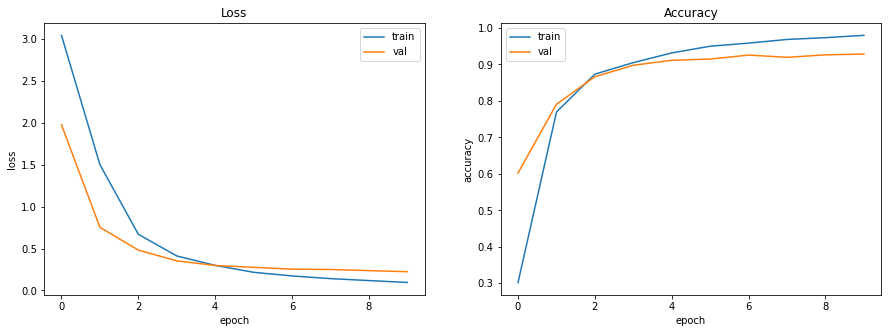

In [ ]:
import matplotlib.pyplot as plt
history = history.history

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='train')
plt.plot(history['val_loss'], label='val')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title("Loss")

plt.subplot(1, 2, 2)
plt.plot(history['accuracy'], label='train')
plt.plot(history['val_accuracy'], label='val')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title("Accuracy")
plt.show()